In [144]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os 
import pickle
import re
import joblib
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
from sklearn.metrics import confusion_matrix

In [145]:
#funciones de apoyo 
def load_df(path):
    """
    Recibe el path en donde se encuentra el pickle que se quiere volver a cargar.
    """
    # Recuperar el pickle
    pkl = pickle.load(open(path, "rb"))

    return pkl


def load_features(path):
    """
    Cargar pickle que se generó durante la transformación
    :param path: Path donde se encuentra el pickle
    :return:
    """
    print("Opening feature engineering pickle from output path")
    output_path = os.path.join(path, "output", "fe_df.pkl")

    # Recuperar el pickle
    incidentes_pkl = load_df(output_path)
    print("Feature Engineering pickle successfully retrieved.")
 
    return incidentes_pkl

def filter_drop(df):
    """
    Función para elegir variables relevantes y tirar los datos vacíos de latitud y longitud. 
    :param df: dataframe a transformar
    :return df: dataframe con las columnas relevantes y sin datos nulos
    """
    print("Dropping columns and Nan's (don't worry, it'll be ok)")
    #solo por seguridad nos aseguramos que estén ordenadas (aunque ya están)
    df = df.sort_values(by=["año_creacion", "mes_creacion", "dia_creacion",
                            "hora_simple"])
    return df.drop(columns=["año_creacion", "mes_creacion", "dia_creacion"]).dropna()

def train_test_split(df, test_size=.70):
    """
    Función para separar en train y test el dataframe.
    Es un poco manual porque son datos temporales -- y no queremos problemas.
    :param df: dataframe a separar en train y test
    :param test_size: fracción entre 0 y 1 que nos permita separar el dataframe. El default es .70
    :return X_train, y_train, X_test, y_test: los 4 fantásticos. 
    """
    if test_size <= 0 or test_size >= 1:
        raise ValueError("Test Size Error. Pick a test size between 0 and 1.")

    #separar features y labels
    print("Performing train test split")
    X = df.drop(columns=["label"]).copy()
    Y = df.label.copy()
    lim = round(df.shape[0] * test_size)  # 70% de train
    X_train, X_test = X[:lim], X[lim:]
    y_train, y_test = Y[:lim], Y[lim:]
    print("Train test split successfully performed")
    return X_train, y_train, X_test, y_test

# Análisis de Sesgo con Aequitas.

El propósito de este notebook es realizar un análisis de sesgo de nuestro modelo utilizando el _framework_ de Aequitas. 

#### Métricas elegidas:

Con base en en el ["Fairness Tree"](https://github.com/ITAM-DS/introduction_to_ds_2020/blob/master/8_audit_bias.md) de Aequitas, y tomando en cuenta que nuestro modelo es un modelo **asistivo**, decidimos elegir las siguientes tres métricas:

* PPR (dado que nos interesa medir la proporción de llamadas que atendemos por colonia)
* FOR Parity (dado que nos interesa apoyar a quienes no estén recibiendo apoyo)
* FNR Parity (dado que nos interesa apoyar con ambulancias a quienes más lo necesiten)

#### Setup del dataframe. 

Aequitas necesita un dataframe con cierto número de columnas. Haremos eso aquí. 

Pero primero recuperaremos el modelo. 

In [146]:
def load_selected_model(path):
    """
    Function to retrieve the model obtained using the magic loop.
    :param path: path to your model
    :param model: name of your model
    :return model: magic model 
    """
    modelo = joblib.load(path) 
    #lo hice con joblib;
    return modelo

In [147]:
PATH = '/Users/Leo/Documents/MCD/1o/IDS/Proyectos/proyecto1/Notebooks/finalized_model.sav'
model = load_selected_model(PATH)
model

LogisticRegression(solver='sag')

Posteriormente recuperamos el set de pruebas.

In [148]:
X_test = pickle.load(open("/Users/Leo/Documents/MCD/1o/IDS/Proyectos/proyecto1/Notebooks/X_test_diciembre4.pkl", "rb"))
y_test = pickle.load(open("/Users/Leo/Documents/MCD/1o/IDS/Proyectos/proyecto1/Notebooks/y_test_diciembre4.pkl", "rb"))

Ahora podemos predecir en el conjunto de prueba y generar las etiquetas. 

In [149]:
predicted_labels = model.predict(X_test)
predicted_scores = model.predict_proba(X_test)
predicted_probs = pd.DataFrame(predicted_scores, columns=["probability_0", "probability_1"])
predicted_probs.head()

,probability_0,probability_1
0,0.751324,0.248676
1,0.733723,0.266277
2,0.847460,0.152540
3,0.733723,0.266277
4,0.714466,0.285534


In [150]:
sum(predicted_labels)

383

Dado el punto de corte de **0.2903** que seleccionamos anteriormente, podemos generar nuevas etiquetas. 

In [151]:
punto_corte = .2903
new_labels = [0 if score < punto_corte else 1 for score in predicted_probs.probability_1]

In [152]:
sum(new_labels)

114477

Podemos ver que con éste nuevo punto de corte, se genera una mayor cantidad de etiquetas positivas.

Ya casi estamos listos para el análisis. Ya tenemos nuestras etiquetas, las etiquetas reales _(y_test)_, ahora solo nos falta la columna de nombres de las delegaciones. 

In [153]:
#Funciones tomadas del notebook de EDA-GEDA, para generar el dataframe original
#con las delegaciones en el orden requerido:
CAT_COLS = ["dia_semana", "codigo_cierre", "año_cierre", "mes_cierre", "mes", "delegacion_inicio", 
            "incidente_c4", "clas_con_f_alarma", "tipo_entrada", "delegacion_cierre", "hora_creacion",
           "hora_cierre"]

DATE_COLS = ["fecha_creacion", "fecha_cierre"]

NUM_COLS = ["latitud", "longitud"]

def ingest_file(file_name):
    """
    Function to retrieve and return the accidents dataset.
    Parameters:
    -----------
    file_name: str
               Path to the file.
    Returns:
    --------
    df: pandas dataframe
    """
    df = pd.read_csv(file_name)
    return df


def drop_cols(df):
    """
    Function to drop unnnecesary columns in the dataset.
    """
    df.drop(columns = ['folio', 'geopoint', 'mes', 'mes_cierre', 'hora_cierre', 'año_cierre'], inplace = True)
    return df



def fill_na(df):
    """
    Function to fill null values in a dataframe.
    """
    #aquí podemos ir agregando más cosas cuando descubramos 
    #cómo imputar valores faltantes para latitud y longitud
    df.fillna({
        'delegacion_inicio': 'No Disponible',
        'delegacion_cierre': 'No Disponible'
              }, inplace = True)
    return df


def categoric_transformation(col,df):
    df[col] = df[col].astype("category")
    return df 

def create_categorical(cols, df):
    """
    Function to transform and prepare the categorical features in the dataset.
    """
    #transform to appropriate data type
    for col in cols: 
        df = categoric_transformation(col, df)
     
    return df


def date_transformation(col,df):
    """
    Function to prepare and transform date-type columns. 
    """
    df[col] = pd.to_datetime(df[col], dayfirst=True)
    return df

def create_date_cols(cols, df):
    for col in cols:
        df = date_transformation(col, df)
    return df 



def generate_label(df):
    """
    Function to create a new column indicating whether there was
    a false alarm or not. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    --------
    df: pandas dataframe
    """
    #transformamos la columna para solo quedarnos con la letra del código
    df["codigo_cierre"] = df["codigo_cierre"].apply(lambda x: x[1])
    df['label'] = np.where(
        (df.codigo_cierre == 'F') | (df.codigo_cierre == 'N'), 1, 0)
    return df 


def clean_hora_creacion(df):
    """
    Function to transform hours with incorrect format to timedelta format. 
    """
    horas_raw = df.hora_creacion.values.tolist()
    horas_clean = [datetime.timedelta(days=float(e)) if e.startswith("0.") else e for e in horas_raw]
    df["hora_creacion"] = horas_clean
    return df 


def create_simple_hour(df):
    """
    Function to extract the hour from the column "hora_creacion"
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the hour. 
    """
    #la función se podria adaptar para devolver minuto o segundo pero no lo considero necesario
    pattern = '\d+' #encuentra uno o más dígitos
    horas_raw = df.hora_creacion.astype(str).values #son así: '22:35:04', '22:50:49', '09:40:11'
    n = len(horas_raw)
    horas_clean = [0]*n #es más rápido reasignar valores que hacer .append()
    for i in range(n):
        hora_raw = horas_raw[i]
        hora_clean = re.match(pattern, hora_raw)[0] #solo queremos la hora, esto devuelve un objeto
        horas_clean[i] = hora_clean
    
    df["hora_simple"] = horas_clean
    return df 


def add_date_columns(df):
    """
    Esta función es muy importante puesto que nos ayudará a crear el mes, día y año de creación
    del registro. De esta manera podemos prescindir de las fechas de cierre, que no tendríamos en tiempo
    real en un modelo. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with 4 new columns
    """
    mapping_meses = {1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo",
                       6: "Junio", 7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre",
                       11: "Noviembre", 12: "Diciembre"}
    
    
    df["año_creacion"] = df.fecha_creacion.dt.year
    df["mes_creacion"] = df.fecha_creacion.dt.month
    df["dia_creacion"] = df.fecha_creacion.dt.day
    df["mes_creacion_str"] = df.mes_creacion.map(mapping_meses)
    df["año_creacion"] = df["año_creacion"].astype(str)
    return df 


def create_time_blocks(df):
    """
    Function to group the hour of the day into 3-hour blocks.
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the time-block.
    """
    horas_int = set(df.hora_simple.astype(int).values) #estaba como categórico
    f = lambda x: 12 if x == 0 else x
    mapping_hours = {}
    for hora in horas_int:
        grupo = (hora // 3) * 3
        if grupo < 12: 
            nombre_grupo = str(f(grupo)) + "-" + str(grupo + 2) + " a.m."
        else:
            hora_tarde = grupo % 12
            nombre_grupo = str(f(hora_tarde)) + "-" + str(hora_tarde + 2) + " p.m."
        mapping_hours[hora] = nombre_grupo
    
    df["espacio_del_dia"] = df["hora_simple"].astype(int).map(mapping_hours)
    return df
    

    

    
def basic_preprocessing(path):
    """
    Function to summarize all the preprocessing done to the data.
    Parameters:
    -----------
    path: str
          Path to your file
    
    Returns:
    ---------
    df: pandas dataframe
    """
    df = ingest_file(path) 
    df = generate_label(df)
    df = fill_na(df) 
    df = clean_hora_creacion(df)
    df = create_categorical(CAT_COLS, df) #transform to appropriate data types
    df = create_date_cols(DATE_COLS, df)
    df = add_date_columns(df)
    df = create_simple_hour(df)
    df = create_time_blocks(df)
    df = drop_cols(df)
    
    return df


In [154]:
data = basic_preprocessing('/Users/Leo/Documents/MCD/1o/IDS/Proyectos/proyecto1/datos/incidentes-viales-c5.csv')

In [155]:
data = filter_drop(data)

Dropping columns and Nan's (don't worry, it'll be ok)


In [156]:
delegaciones = data.delegacion_inicio.iloc[967884:]

Confirmamos que nuestros datos tengan las dimensiones correctas:

In [157]:
print(X_test.shape, y_test.shape, len(new_labels), len(delegaciones))

(414808, 62) (414808,) 414808 414808


Creamos el dataframe con el que se hará el análisis:

In [158]:
aeq_df = pd.DataFrame({"score": new_labels, 
                       "label_value": y_test.values,
                       "delegacion": delegaciones}
                    ).reset_index().iloc[:,1:]
aeq_df.head()

,score,label_value,delegacion
0,0,0,CUAUHTEMOC
1,0,0,CUAJIMALPA
2,0,1,MIGUEL HIDALGO
3,0,0,CUAJIMALPA
4,0,0,MIGUEL HIDALGO


Damos formato a la columna `delegacion`:

In [159]:
aeq_df.delegacion = aeq_df.delegacion.apply(lambda x: x.lower().title())
aeq_df["delegacion"] = aeq_df["delegacion"].astype(str)
aeq_df.head()

,score,label_value,delegacion
0,0,0,Cuauhtemoc
1,0,0,Cuajimalpa
2,0,1,Miguel Hidalgo
3,0,0,Cuajimalpa
4,0,0,Miguel Hidalgo


Eso es todo. Podemos proceder a realizar el análisis de sesgo. 

In [160]:
print(f"Predicciones positivas: {aeq_df['score'].astype(int).sum():,}")
print(f"Etiquetas Positivas y_test: {aeq_df['label_value'].astype(int).sum():,}")
print(f"Total de observaciones: {len(aeq_df):,}")

Predicciones positivas: 114,477
Etiquetas Positivas y_test: 80,933
Total de observaciones: 414,808


## Análisis con `Group`:

In [161]:
g = Group()
xtab, attrbs = g.get_crosstabs(aeq_df)
xtab

model_id, score_thresholds 0 {'rank_abs': [114477]}


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,114477,delegacion,Alvaro Obregon,0.543814,0.678411,0.147988,0.695992,0.321589,...,0.367207,7658,2806,16155,3345,6151,23813,29964,414808,0.205280
1,0,binary 0/1,114477,delegacion,Azcapotzalco,0.122367,0.945485,0.155179,0.692437,0.054515,...,0.065724,824,2625,14291,366,2991,15115,18106,414808,0.165194
2,0,binary 0/1,114477,delegacion,Benito Juarez,0.133244,0.938898,0.156398,0.695443,0.061102,...,0.073167,1587,4521,24386,695,5216,25973,31189,414808,0.167238
3,0,binary 0/1,114477,delegacion,Coyoacan,0.558788,0.682697,0.145367,0.683298,0.317303,...,0.367617,7957,2912,17120,3688,6600,25077,31677,414808,0.208353
4,0,binary 0/1,114477,delegacion,Cuajimalpa,0.514692,0.679442,0.215538,0.618188,0.320558,...,0.374490,1815,1057,3847,1121,2178,5662,7840,414808,0.277806
5,0,binary 0/1,114477,delegacion,Cuauhtemoc,0.118832,0.945976,0.145214,0.713695,0.054024,...,0.064020,1897,5643,33217,761,6404,35114,41518,414808,0.154246
6,0,binary 0/1,114477,delegacion,Gustavo A. Madero,0.409298,0.777455,0.152596,0.696430,0.222545,...,0.258326,7433,4676,25967,3240,7916,33400,41316,414808,0.191596
7,0,binary 0/1,114477,delegacion,Iztacalco,0.401696,0.771330,0.153255,0.709274,0.228670,...,0.261405,3235,1975,10912,1326,3301,14147,17448,414808,0.189191
8,0,binary 0/1,114477,delegacion,Iztapalapa,0.581087,0.647450,0.149358,0.690950,0.352550,...,0.401330,19178,6184,35220,8578,14762,54398,69160,414808,0.213447
9,0,binary 0/1,114477,delegacion,Magdalena Contreras,0.636872,0.638429,0.154435,0.638732,0.361571,...,0.428485,1814,585,3203,1026,1611,5017,6628,414808,0.243060


In [162]:
#Métricas absolutas
absolute_metrics = g.list_absolute_metrics(xtab)
#absolute_metrics

### Tabla de conteo de frecuencias por `Group`:

In [163]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,114477,delegacion,Alvaro Obregon,11003,18961,7658,2806,16155,3345,6151,23813,29964,414808
1,0,binary 0/1,114477,delegacion,Azcapotzalco,1190,16916,824,2625,14291,366,2991,15115,18106,414808
2,0,binary 0/1,114477,delegacion,Benito Juarez,2282,28907,1587,4521,24386,695,5216,25973,31189,414808
3,0,binary 0/1,114477,delegacion,Coyoacan,11645,20032,7957,2912,17120,3688,6600,25077,31677,414808
4,0,binary 0/1,114477,delegacion,Cuajimalpa,2936,4904,1815,1057,3847,1121,2178,5662,7840,414808
5,0,binary 0/1,114477,delegacion,Cuauhtemoc,2658,38860,1897,5643,33217,761,6404,35114,41518,414808
6,0,binary 0/1,114477,delegacion,Gustavo A. Madero,10673,30643,7433,4676,25967,3240,7916,33400,41316,414808
7,0,binary 0/1,114477,delegacion,Iztacalco,4561,12887,3235,1975,10912,1326,3301,14147,17448,414808
8,0,binary 0/1,114477,delegacion,Iztapalapa,27756,41404,19178,6184,35220,8578,14762,54398,69160,414808
9,0,binary 0/1,114477,delegacion,Magdalena Contreras,2840,3788,1814,585,3203,1026,1611,5017,6628,414808


### Tabla de conteo de absolutos por `Group`:

In [164]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion,Alvaro Obregon,0.54,0.68,0.15,0.70,0.32,0.46,0.85,0.30,0.10,0.37,0.21
1,delegacion,Azcapotzalco,0.12,0.95,0.16,0.69,0.05,0.88,0.84,0.31,0.01,0.07,0.17
2,delegacion,Benito Juarez,0.13,0.94,0.16,0.70,0.06,0.87,0.84,0.30,0.02,0.07,0.17
3,delegacion,Coyoacan,0.56,0.68,0.15,0.68,0.32,0.44,0.85,0.32,0.10,0.37,0.21
4,delegacion,Cuajimalpa,0.51,0.68,0.22,0.62,0.32,0.49,0.78,0.38,0.03,0.37,0.28
5,delegacion,Cuauhtemoc,0.12,0.95,0.15,0.71,0.05,0.88,0.85,0.29,0.02,0.06,0.15
6,delegacion,Gustavo A. Madero,0.41,0.78,0.15,0.70,0.22,0.59,0.85,0.30,0.09,0.26,0.19
7,delegacion,Iztacalco,0.40,0.77,0.15,0.71,0.23,0.60,0.85,0.29,0.04,0.26,0.19
8,delegacion,Iztapalapa,0.58,0.65,0.15,0.69,0.35,0.42,0.85,0.31,0.24,0.40,0.21
9,delegacion,Magdalena Contreras,0.64,0.64,0.15,0.64,0.36,0.36,0.85,0.36,0.02,0.43,0.24


### Visualización de métricas por `Group`:

In [166]:
#En aequitas nuestras métricas son PPR, FOR y FNR.
aeq = Plot()

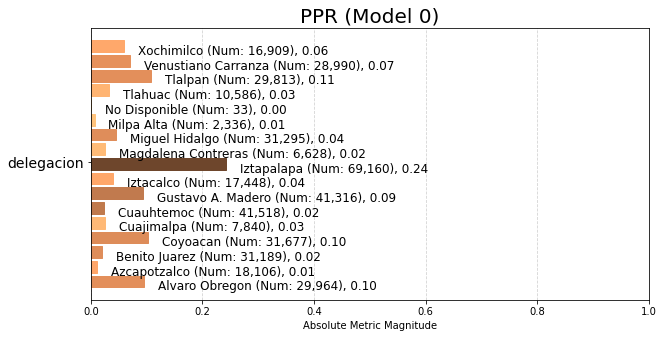

In [167]:
fdr = aeq.plot_group_metric(xtab, 'ppr')

Podemos ver que, excepto por Iztapalapa, en general la mayoría de las colonias tienen una proporción baja de predicciones positivas. 

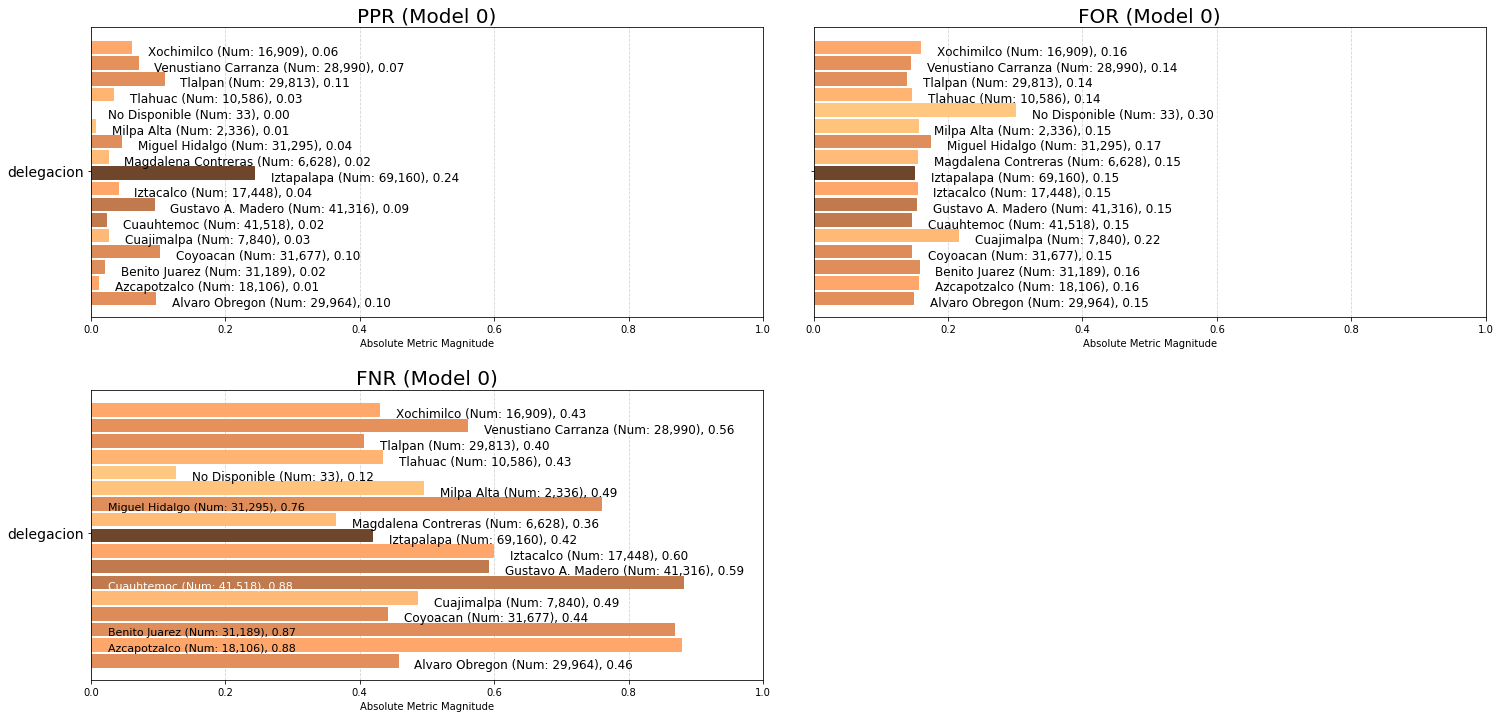

<Figure size 432x288 with 0 Axes>

In [168]:
p = aeq.plot_group_metric_all(xtab, metrics=['ppr','for','fnr'], ncols = 2)

Interpretación de cada métrica seleccionada:
* **PPR** (_Predicted Positive Rate_): Como ya se había mencionado, Iztapalapa es la delegación con más predicción de positivos, por un margen bastante alto.
* **FOR** (_False Omission Rate_):  Aún contando con pocas observaciones, la categoría "No disponible" de las delegaciones, es la que cuenta con la _FOR_ más alta.  En segundo lugar se encuentra Cuajimalpa, lo que hace sentido, puesto que cuenta con una de las tasas más altas de llamadas falsas (observado en nuestro EDA/GEDA), por lo que podemos tener llamadas con etiqueta negativa (llamada verdadera), cuando en realidad debía ser una etiqueta positiva (llamada falsa).
* **FNR** (_False Negative Rate_):  Llama la atención que la tasa de FNR es muy alta para prácticamente todas las delegaciones.  Esto es preocupante puesto que al tratarse de falsos negativos (llamadas falsas clasificadas como verdaderas), se pueden estar mandando ambulancias a eventos donde no es necesario.  Desgraciadamente, es un comportamiento esperado dada la baja precisión de nuestro modelo.

Mostramos la matriz de confusión como referencia:

In [169]:
pd.DataFrame(confusion_matrix(y_test, new_labels))

,0,1
0,254570,79305
1,45761,35172


### Análisis de Sesgo. 

Primero pondremos como referencia a **Iztalapa** por ser la colonia con más predicciones positivas

In [170]:
bias = Bias()

In [171]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df = aeq_df, 
                                ref_groups_dict = {'delegacion': 'Iztapalapa'}, 
                                alpha=0.05)

get_disparity_predefined_group()


In [172]:
bdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,114477,delegacion,Alvaro Obregon,0.543814,0.678411,0.147988,0.695992,0.321589,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
1,0,binary 0/1,114477,delegacion,Azcapotzalco,0.122367,0.945485,0.155179,0.692437,0.054515,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
2,0,binary 0/1,114477,delegacion,Benito Juarez,0.133244,0.938898,0.156398,0.695443,0.061102,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
3,0,binary 0/1,114477,delegacion,Coyoacan,0.558788,0.682697,0.145367,0.683298,0.317303,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
4,0,binary 0/1,114477,delegacion,Cuajimalpa,0.514692,0.679442,0.215538,0.618188,0.320558,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
5,0,binary 0/1,114477,delegacion,Cuauhtemoc,0.118832,0.945976,0.145214,0.713695,0.054024,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
6,0,binary 0/1,114477,delegacion,Gustavo A. Madero,0.409298,0.777455,0.152596,0.696430,0.222545,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
7,0,binary 0/1,114477,delegacion,Iztacalco,0.401696,0.771330,0.153255,0.709274,0.228670,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
8,0,binary 0/1,114477,delegacion,Iztapalapa,0.581087,0.647450,0.149358,0.690950,0.352550,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa
9,0,binary 0/1,114477,delegacion,Magdalena Contreras,0.636872,0.638429,0.154435,0.638732,0.361571,...,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa,Iztapalapa


### Tabla de análisis de sesgo por `Bias` (por mayoría):

In [173]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=aeq_df)

get_disparity_major_group()


In [174]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,Alvaro Obregon,0.40,0.91,0.98,1.01,0.99,0.91,1.09,0.94,1.05,1.00
1,delegacion,Azcapotzalco,0.04,0.16,1.00,1.00,1.04,0.15,2.10,0.21,1.46,0.99
2,delegacion,Benito Juarez,0.08,0.18,0.99,1.01,1.05,0.17,2.07,0.23,1.45,0.99
3,delegacion,Coyoacan,0.42,0.92,1.02,0.99,0.97,0.90,1.05,0.96,1.05,1.00
4,delegacion,Cuajimalpa,0.11,0.93,1.24,0.89,1.44,0.91,1.16,0.89,1.05,0.92
5,delegacion,Cuauhtemoc,0.10,0.16,0.93,1.03,0.97,0.15,2.10,0.20,1.46,1.00
6,delegacion,Gustavo A. Madero,0.38,0.64,0.98,1.01,1.02,0.63,1.41,0.70,1.20,1.00
7,delegacion,Iztacalco,0.16,0.65,0.94,1.03,1.03,0.65,1.43,0.69,1.19,1.00
8,delegacion,Iztapalapa,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,delegacion,Magdalena Contreras,0.10,1.07,1.17,0.92,1.03,1.03,0.87,1.10,0.99,0.99


Análisis por minoría. Ahora podemos analizar el sesgo a partir de la colonia con _menos_ predicciones positivas. Veamos los resultados. 

In [175]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=aeq_df)

get_disparity_min_metric()


### Tabla de análisis de sesgo por `Bias` (por minoría):

In [176]:
min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,Alvaro Obregon,478.39,5.74,1.09,8.00,1.08,5.95,3.65,4.58,1.08,1.22
1,delegacion,Azcapotzalco,51.74,1.03,1.10,7.96,1.13,1.01,7.02,1.03,1.50,1.21
2,delegacion,Benito Juarez,99.22,1.14,1.09,8.00,1.14,1.13,6.93,1.12,1.49,1.21
3,delegacion,Coyoacan,506.30,5.74,1.13,7.86,1.06,5.87,3.53,4.70,1.08,1.22
4,delegacion,Cuajimalpa,127.65,5.85,1.37,7.11,1.57,5.93,3.88,4.33,1.08,1.12
5,delegacion,Cuauhtemoc,115.57,1.00,1.02,8.21,1.06,1.00,7.05,1.00,1.50,1.22
6,delegacion,Gustavo A. Madero,464.04,4.04,1.09,8.01,1.11,4.12,4.73,3.44,1.24,1.21
7,delegacion,Iztacalco,198.30,4.08,1.04,8.16,1.12,4.23,4.79,3.38,1.23,1.21
8,delegacion,Iztapalapa,1206.78,6.27,1.10,7.95,1.09,6.53,3.35,4.89,1.03,1.22
9,delegacion,Magdalena Contreras,123.48,6.69,1.29,7.35,1.12,6.69,2.91,5.36,1.01,1.21


## Visualización de sesgo por `Bias`:

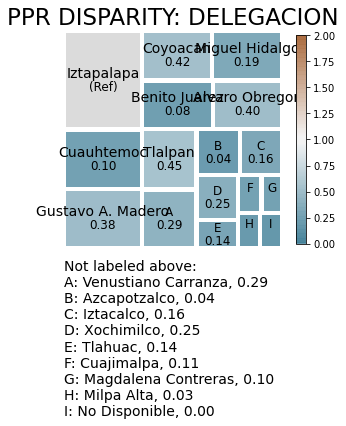

In [177]:
ppr_disparity = aeq.plot_disparity(bdf, group_metric='ppr_disparity', 
                                   attribute_name='delegacion', 
                                   significance_alpha=0.05)

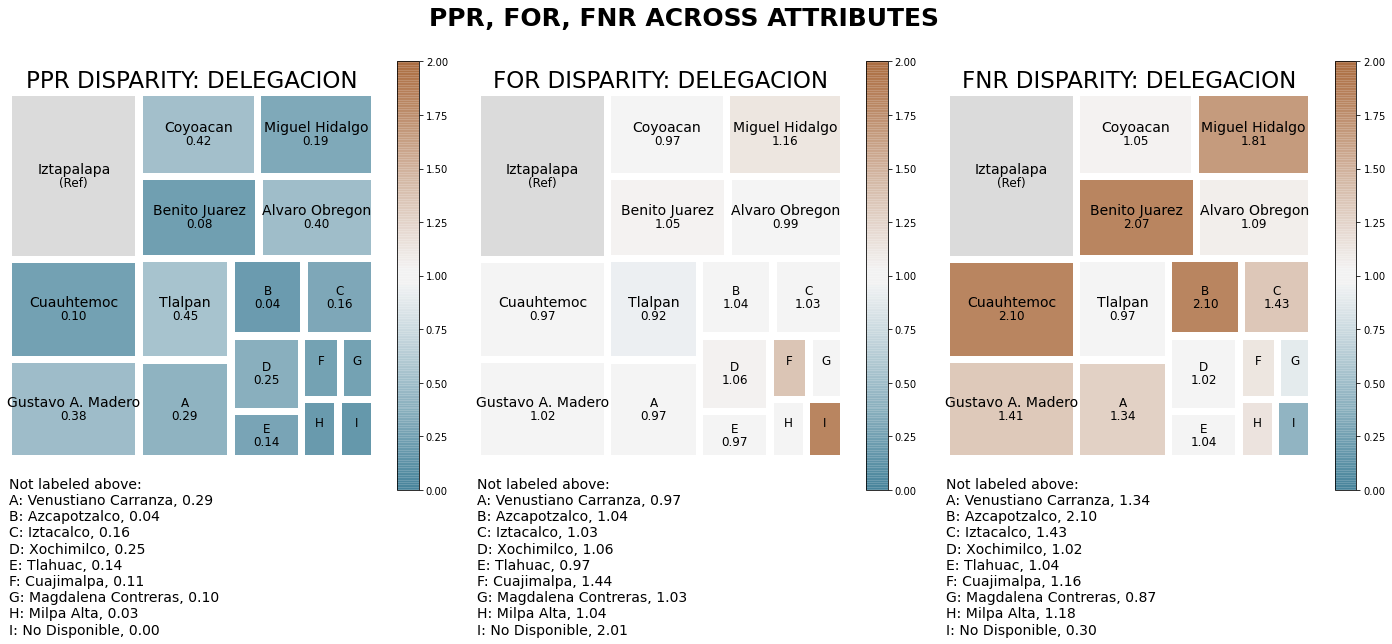

In [178]:
p = aeq.plot_disparity_all(majority_bdf,  metrics=['ppr','for','fnr'], significance_alpha=0.05)

Usando a Iztapalapa como referencia (por tener el número más alto observaciones), observamos lo siguiente en las métricas de interés:

* **PPR**: Todas las delegaciones tienen un _PPR_ más bajo (comportamiento esperado).
* **FOR**: Parecería que la delegación Iztapalapa es relativamente media, hay varias delegaciones por encima y por debajo respecto a esta métrica.  La más lejana hacia arriba es No disponible seguida de Cuajimalpa, y la más lejana hacia abajo es Tlalpan, por un margen relativamente pequeño.  Esto podría significar que mandamos más ambulancias en vano a Cuajimalpa.
* **FNR**:  Se observa una mayor disparidad.  Ahora "No disponible" es la más lejana hacia bajo, seguida por Magdalena Contreras por un margen relativamente pequeño respecto a Iztapalapa.  Las más lejanas hacia arriba son Azcapotzalco y Cuauhtémoc.

## Análisis de Justicia (_Fairness_):

In [179]:
f = Fairness()

In [180]:
fdf = f.get_group_value_fairness(bdf)

In [181]:
parity_determinations = f.list_parities(fdf)

In [182]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,Equalized Odds,FNR Parity,Supervised Fairness,Statistical Parity,Precision Parity,TypeII Parity,FPR Parity,TNR Parity,FOR Parity,NPV Parity
0,delegacion,Alvaro Obregon,0.54,0.68,0.15,0.70,0.32,0.46,0.85,0.30,...,True,True,True,False,True,True,True,True,True,True
1,delegacion,Azcapotzalco,0.12,0.95,0.16,0.69,0.05,0.88,0.84,0.31,...,False,False,False,False,True,False,False,False,True,True
2,delegacion,Benito Juarez,0.13,0.94,0.16,0.70,0.06,0.87,0.84,0.30,...,False,False,False,False,True,False,False,False,True,True
3,delegacion,Coyoacan,0.56,0.68,0.15,0.68,0.32,0.44,0.85,0.32,...,True,True,True,False,True,True,True,True,True,True
4,delegacion,Cuajimalpa,0.51,0.68,0.22,0.62,0.32,0.49,0.78,0.38,...,True,True,False,False,True,False,True,True,False,True
5,delegacion,Cuauhtemoc,0.12,0.95,0.15,0.71,0.05,0.88,0.85,0.29,...,False,False,False,False,True,False,False,False,True,True
6,delegacion,Gustavo A. Madero,0.41,0.78,0.15,0.70,0.22,0.59,0.85,0.30,...,False,False,False,False,True,False,False,True,True,True
7,delegacion,Iztacalco,0.40,0.77,0.15,0.71,0.23,0.60,0.85,0.29,...,False,False,False,False,True,False,False,True,True,True
8,delegacion,Iztapalapa,0.58,0.65,0.15,0.69,0.35,0.42,0.85,0.31,...,True,True,True,True,True,True,True,True,True,True
9,delegacion,Magdalena Contreras,0.64,0.64,0.15,0.64,0.36,0.36,0.85,0.36,...,True,True,True,False,True,True,True,True,True,True


Podemos ver la equidad a nivel de atributos:

In [183]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


Podemos ver que nuestro modelo es injusto para prácticamente todas las métricas, con excepción de **NPV** (Negative Predictive Value).

In [184]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

## Visualización de Equidad (_Fairness_):

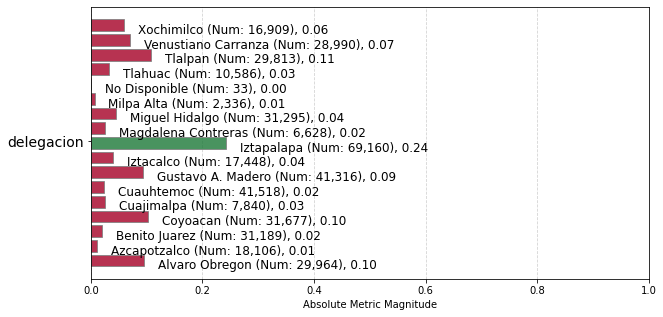

In [185]:
z = aeq.plot_fairness_group(fdf, group_metric='ppr')

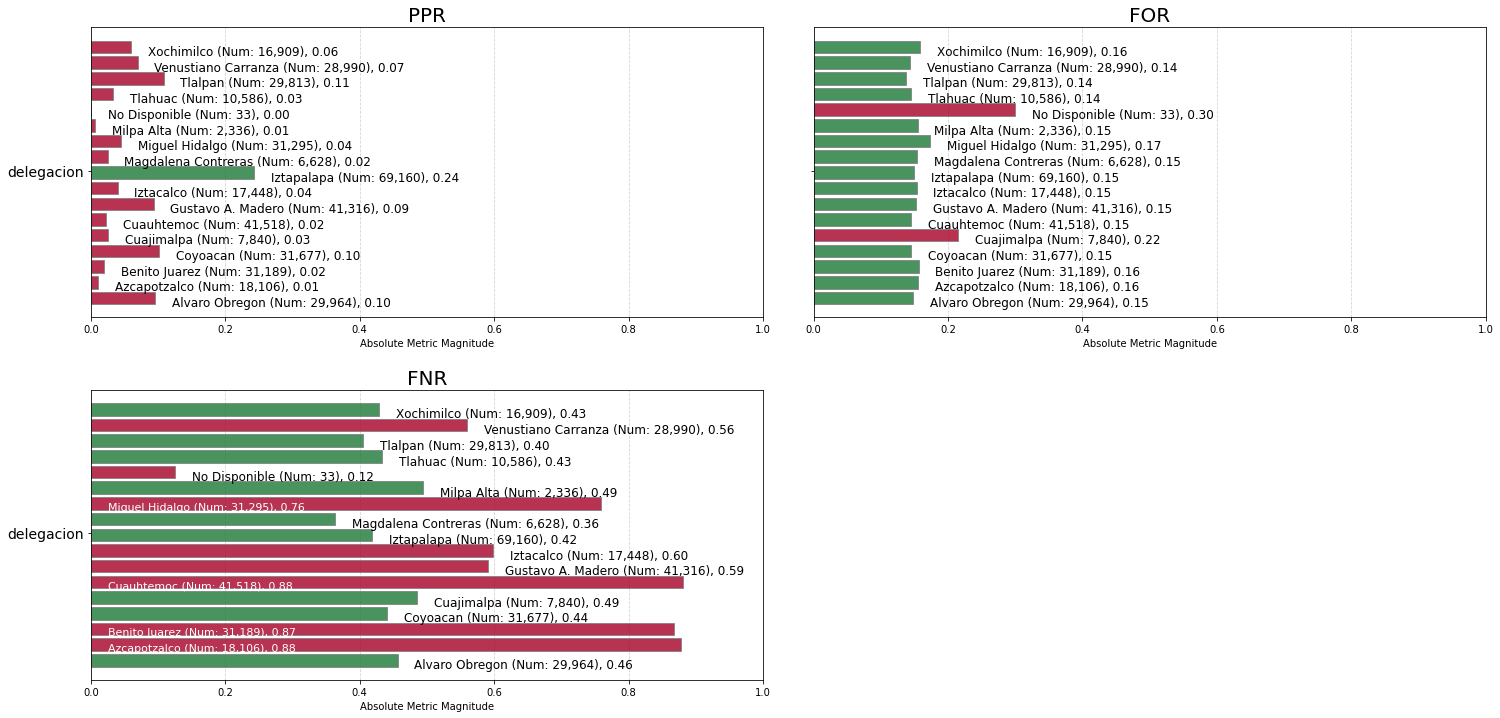

<Figure size 432x288 with 0 Axes>

In [186]:
z = aeq.plot_fairness_group_all(fdf, metrics=['ppr','for','fnr'], ncols = 2)

Similar a lo que se había observado anteriormente, se puede concluir lo siguiente:

* **PPR**: Iztapalapa parecería ser la delegación con más propensión a las etiquetas positivas, esto puede ser peligroso pues se pueden dejar de enviar ambulancias en ocasiones que sí sería necesario.  Se observa una gran disparidad con el resto de las delegaciones respecto a Iztapalapa.  En la gráfica se observa de color verde por ser el grupo de referencia.
* **FOR**: Cuajimalpa parecería ser la delegación que resulta más beneficiada con la _FOR_ más alta.  Se podrían estar mandando ambulancias en vano.  Basado en los colores, parece ser de las métricas con mayor justicia de nuestro modelo.
* **FNR**:  Se observa una menor justicia de nuestro modelo, es un comportamiento esperado dada la baja precisión de nuestro modelo.  